## Set base dirs

In [1]:
base_dir = '/monfs01/projects/ys68/XRD_SPG_analysis'
data_dir = 'training_data'
trained_models_dir = 'trained_models'

## Imports

In [2]:
# Cell 1: Imports and Setup
import os
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from ase.db import connect
import pandas as pd
from tqdm.notebook import tqdm

# Set the working directory to the base of the repo 
os.chdir(base_dir)
from src.data_loading.simXRD_data_loader import create_inference_data_loader

%matplotlib inline
plt.style.use('seaborn-v0_8')

## Loading data

In [3]:
# data sub folders
partial_dir = "simXRD_partial_data"
monash_dir = "monash_data"

# Set datasets
datasets = {
    "Partial Training set": os.path.join(data_dir, partial_dir, 'train.db'),
    "Partial Validation set": os.path.join(data_dir, partial_dir, 'val.db'),
    "Partial Test set": os.path.join(data_dir, partial_dir, 'test.db'),

    "Monash Madsen": os.path.join(data_dir, monash_dir, "madsen_2001")
}

# Print sizes (only for .db files)
print("=== Dataset Sizes ===")
print("Partial Dataset:")
total_samples = 0
for name, path in datasets.items():
    if path.endswith('.db'):
        size = connect(path).count()
        total_samples += size
        print(f"{name}: {size:,} samples")
print(f"\nTotal database samples: {total_samples:,}")

=== Dataset Sizes ===
Partial Dataset:
Partial Training set: 5,000 samples
Partial Validation set: 1,000 samples
Partial Test set: 2,000 samples

Total database samples: 8,000


## Analyse an example DB file

In [4]:
# Which data do you want to look at?
data_set_in_use = datasets["Partial Test set"]

# Number of samples to plot
samples_to_show = 1

### Plot

In [5]:
# Cell: Data Inspection Helper Functions
def get_crystal_system_name(system_id):
    """Convert crystal system ID to name."""
    crystal_systems = {
        1: "Cubic",
        2: "Hexagonal",
        3: "Tetragonal",
        4: "Orthorhombic",
        5: "Trigonal",
        6: "Monoclinic",
        7: "Triclinic"
    }
    return crystal_systems.get(system_id, "Unknown")

def plot_sample_xrd(intensity, lattice_dist, formula, spg, crysystem, blt, mass):
    """Plot a single XRD pattern with detailed information."""
    plt.figure(figsize=(15, 6))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_palette("husl")
    
    # Create the main plot
    plt.plot(lattice_dist, intensity, linewidth=1.5)
    
    # Labels and title
    plt.xlabel('Lattice Plane Distance (Å)', fontsize=12)
    plt.ylabel('Intensity (a.u.)', fontsize=12)
    plt.title(f'X-ray Diffraction Pattern', fontsize=14, pad=20)
    
    # Add sample information
    info_text = (
        f'Chemical Formula: {formula}\n'
        f'Space Group: {spg}\n'
        f'Crystal System: {get_crystal_system_name(crysystem)}\n'
        f'Bravais Lattice: {blt}\n'
        f'Mass: {mass:.2f} u'
    )
    
    # Add text box with sample information
    plt.text(0.95, 0.95, info_text,
             transform=plt.gca().transAxes,
             fontsize=10,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round',
                      facecolor='white',
                      alpha=0.8))
    
    # Customize grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Tight layout
    plt.tight_layout()
    plt.show()

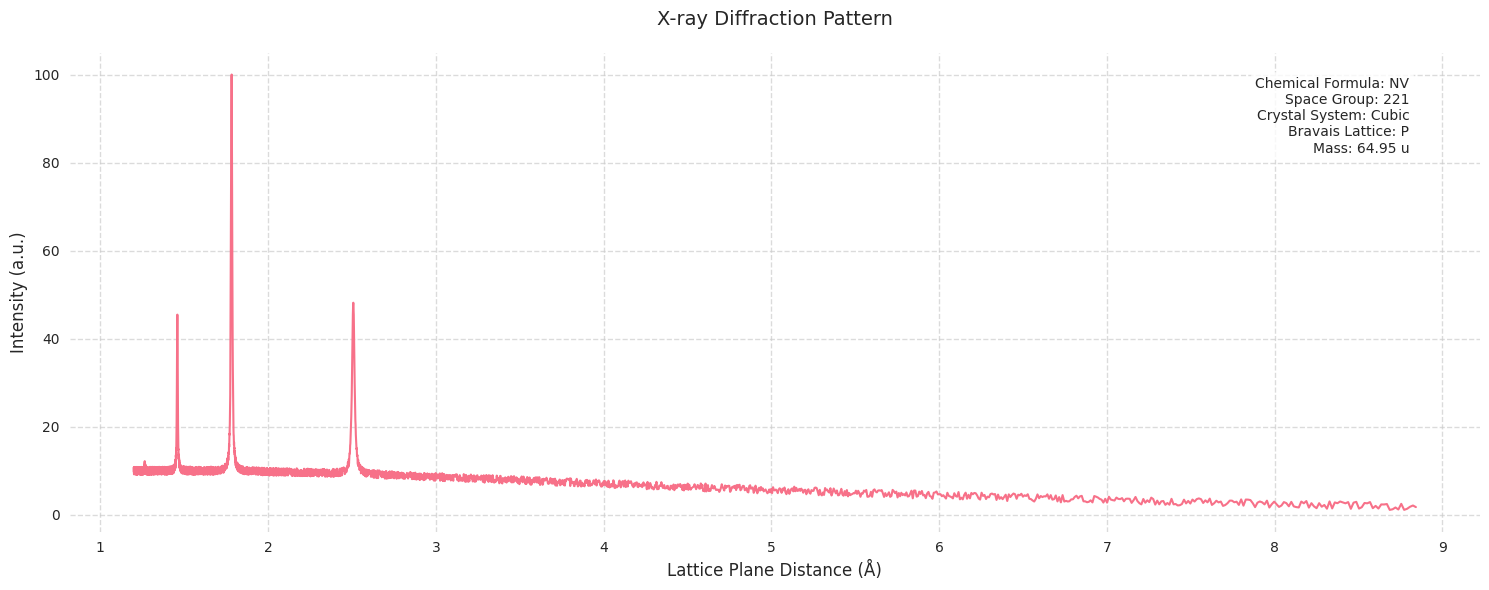

=== Database XRD Format Analysis ===
Intensity vector shape: (3501,)
Lattice distance vector shape: (3501,)
d-spacing range: 8.8416Å - 1.1993Å
d-spacing step size: -0.002184Å


In [ ]:
# Load a few samples from the test dataset
db = connect(data_set_in_use)
samples = []

for i in range(samples_to_show):  # Get x samples
    row = db.get(i)
    sample = {
        'chemical_formula': row.chem_form,
        'intensity': eval(row.intensity),
        'lattice_dist': eval(row.latt_dis),
        'space_group': eval(row.tager)[0],
        'crystal_system': eval(row.tager)[1],
        'bravais_lattice': eval(row.tager)[2],
        'mass': row.mass
    }
    samples.append(sample)

# Plot samples
for sample in samples:
    plot_sample_xrd(
        sample['intensity'],
        sample['lattice_dist'],
        sample['chemical_formula'],
        sample['space_group'],
        sample['crystal_system'],
        sample['bravais_lattice'],
        sample['mass']
    )


# Print the format
# Get first entry
row = db.get(1)  

# Extract data
db_intensity = np.array(eval(row.intensity))
db_latt_dis = np.array(eval(row.latt_dis))

print(f"=== Database XRD Format Analysis ===")
print(f"Intensity vector shape: {db_intensity.shape}")
print(f"Lattice distance vector shape: {db_latt_dis.shape}")
print(f"d-spacing range: {db_latt_dis[0]:.4f}Å - {db_latt_dis[-1]:.4f}Å")
print(f"d-spacing step size: {np.mean(np.diff(db_latt_dis)):.6f}Å")
    

### Stats

=== Dataset Statistics ===


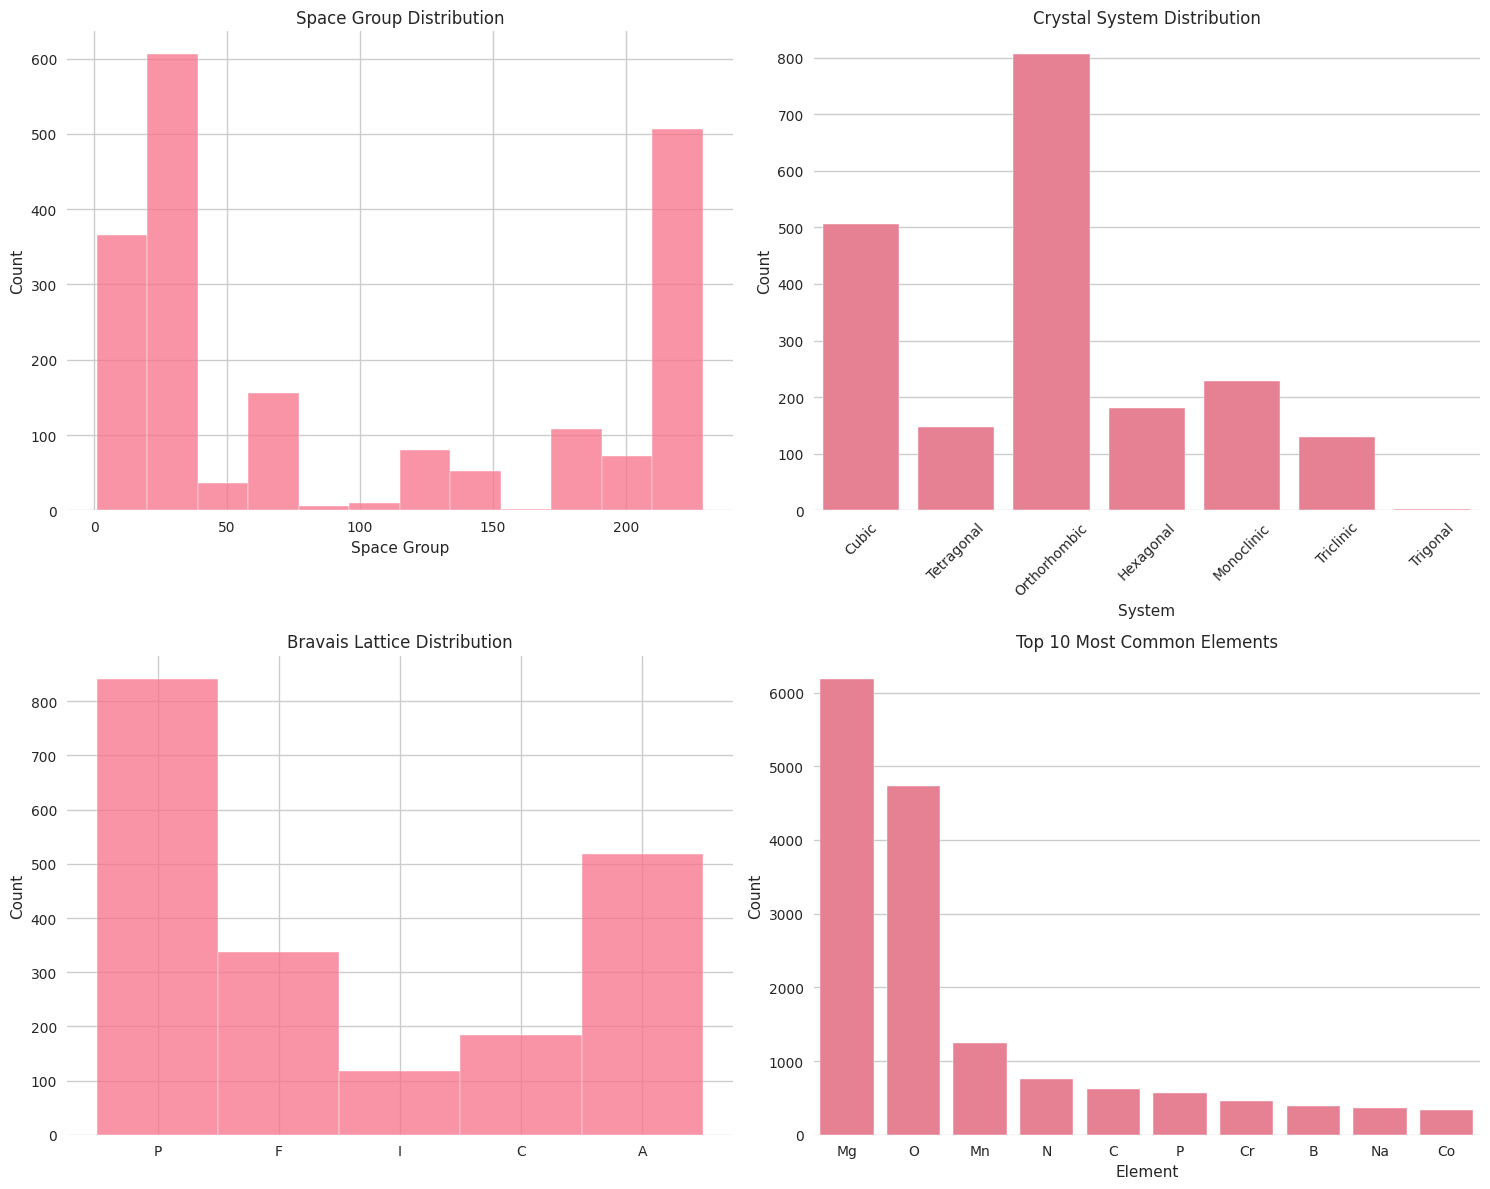

In [7]:
# Cell: Dataset Statistics
print("=== Dataset Statistics ===")
stats = {
    'space_groups': [],
    'crystal_systems': [],
    'bravais_lattices': [],
    'elements': []
}

for row in db.select():
    tager = eval(row.tager)
    stats['space_groups'].append(tager[0])
    stats['crystal_systems'].append(tager[1])
    stats['bravais_lattices'].append(tager[2])
    stats['elements'].extend(row.symbols)

# Create distribution plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Space Groups
sns.histplot(stats['space_groups'], ax=axes[0,0])
axes[0,0].set_title('Space Group Distribution')
axes[0,0].set_xlabel('Space Group')

# Crystal Systems
crystal_counts = Counter(stats['crystal_systems'])
crystal_df = pd.DataFrame([
    {'System': get_crystal_system_name(k), 'Count': v} 
    for k, v in crystal_counts.items()
])
sns.barplot(data=crystal_df, x='System', y='Count', ax=axes[0,1])
axes[0,1].set_title('Crystal System Distribution')
axes[0,1].tick_labels = plt.setp(axes[0,1].xaxis.get_majorticklabels(), rotation=45)

# Bravais Lattices
sns.histplot(stats['bravais_lattices'], ax=axes[1,0])
axes[1,0].set_title('Bravais Lattice Distribution')

# Elements
element_counts = Counter(stats['elements']).most_common(10)
element_df = pd.DataFrame(element_counts, columns=['Element', 'Count'])
sns.barplot(data=element_df, x='Element', y='Count', ax=axes[1,1])
axes[1,1].set_title('Top 10 Most Common Elements')

plt.tight_layout()
plt.show()

## Look at the conversion of Round Robin 2001 samples to model format

In [8]:
def load_xy_file(file_path):
    """Load and parse an XY file."""
    try:
        # Load the XY file (typically space or tab-separated)
        data = np.loadtxt(file_path)
        x_data = data[:, 0]  # First column (angles/distances)
        y_data = data[:, 1]  # Second column (intensities)
        return x_data, y_data
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

In [9]:
def two_theta_to_d_spacing(two_theta, wavelength):
    """Convert 2θ to d-spacing."""
    theta = np.radians(two_theta) / 2
    d_spacing = wavelength / (2 * np.sin(theta))
    return d_spacing

def interpolate_to_db_format(d_spacing, intensity, db_latt_dis):
    """Interpolate data to match database format."""
    # Interpolate intensity to match database lattice distances
    intensity_interp = np.interp(
        db_latt_dis,
        d_spacing,
        intensity,
        left=0,  # Set values outside range to 0
        right=0
    )
    return intensity_interp

def process_xy_file(file_path, wavelength, db_latt_dis):
    """Process XY file to match database format."""
    # Load data
    two_theta, intensity = load_xy_file(file_path)
    
    if two_theta is None:
        return None, None
    
    # Convert to d-spacing
    d_spacing = two_theta_to_d_spacing(two_theta, wavelength)
    
    # Sort by d-spacing
    sort_idx = np.argsort(d_spacing)
    d_spacing = d_spacing[sort_idx]
    intensity = intensity[sort_idx]
    
    # Normalize intensity to max=100
    intensity = (intensity / np.max(intensity)) * 100
    
    # Interpolate to match database format
    intensity_matched = interpolate_to_db_format(d_spacing, intensity, db_latt_dis)
    
    return db_latt_dis, intensity_matched

In [10]:
def plot_conversion_comparison(file_path, wavelength, db_latt_dis):
    """Plot detailed comparison of original and converted data."""
    two_theta, original_intensity = load_xy_file(file_path)
    d_spacing_matched, intensity_matched = process_xy_file(file_path, wavelength, db_latt_dis)
    
    if two_theta is None or d_spacing_matched is None:
        return
        
    # Calculate intermediate d-spacing (before interpolation)
    d_spacing_orig = two_theta_to_d_spacing(two_theta, wavelength)
    sort_idx = np.argsort(d_spacing_orig)
    d_spacing_orig = d_spacing_orig[sort_idx]
    original_intensity = original_intensity[sort_idx]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Original 2θ plot
    ax1.plot(two_theta, original_intensity, linewidth=1.5)
    ax1.set_xlabel('2θ (degrees)', fontsize=12)
    ax1.set_ylabel('Intensity (original)', fontsize=12)
    ax1.set_title('Original XRD Pattern (2θ)', fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Add original data info
    orig_info = (
        f'Original Format:\n'
        f'Points: {len(two_theta)}\n'
        f'2θ range: {two_theta[0]:.2f}° - {two_theta[-1]:.2f}°\n'
        f'Intensity range: {np.min(original_intensity):.1f} - {np.max(original_intensity):.1f}'
    )
    ax1.text(0.95, 0.95, orig_info,
             transform=ax1.transAxes,
             fontsize=10,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round',
                      facecolor='white',
                      alpha=0.8))
    
    # Converted d-spacing plot
    ax2.plot(d_spacing_matched, intensity_matched, linewidth=1.5)
    ax2.set_xlabel('d-spacing (Å)', fontsize=12)
    ax2.set_ylabel('Intensity (normalized)', fontsize=12)
    ax2.set_title('Converted XRD Pattern (d-spacing)', fontsize=14)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Add conversion info
    conv_info = (
        f'Converted Format:\n'
        f'Points: {len(intensity_matched)}\n'
        f'd-spacing range: {d_spacing_matched[0]:.4f}Å - {d_spacing_matched[-1]:.4f}Å\n'
        f'Step size: {np.mean(np.diff(d_spacing_matched)):.6f}Å\n'
        f'Normalized: Yes (max=100)\n'
        f'Interpolation: Linear\n'
        f'Wavelength: {wavelength}Å'
    )
    ax2.text(0.95, 0.95, conv_info,
             transform=ax2.transAxes,
             fontsize=10,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round',
                      facecolor='white',
                      alpha=0.8))
    
    plt.tight_layout()
    plt.show()

### Save conversion and display example


Converting CORUNDUM.xy:


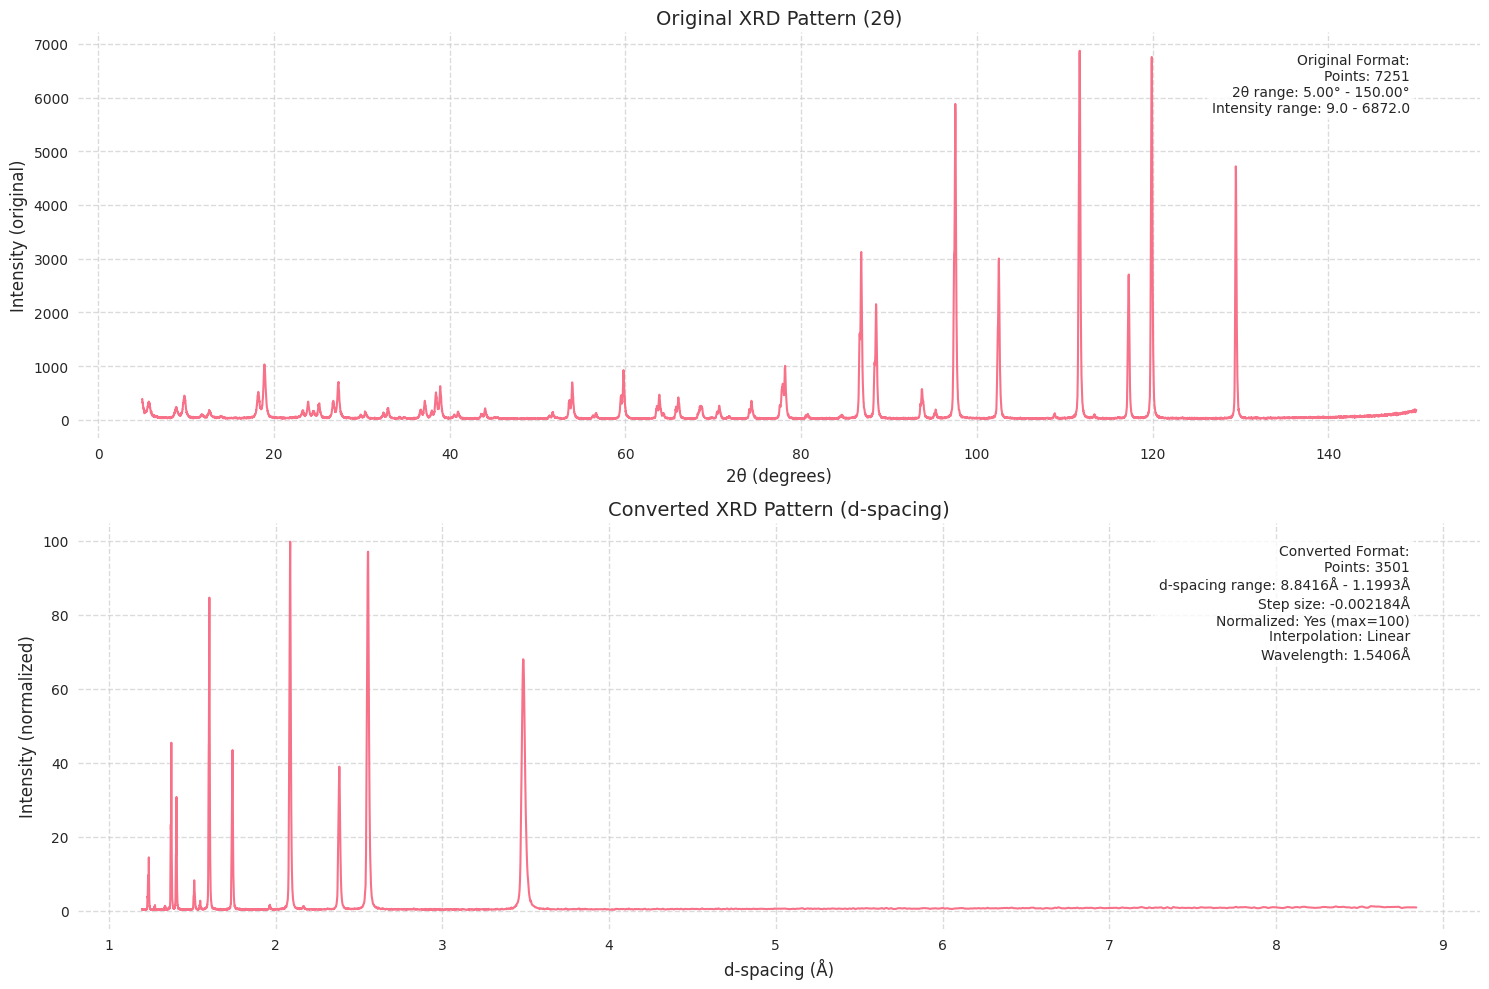

In [11]:
wavelength = 1.5406  # Cu Kα
monash_files = [f for f in os.listdir(datasets["Monash Madsen"]) if f.endswith('.xy')]
converted_intensities = []  # Store just the intensity vectors

for i, file in enumerate(monash_files):
    file_path = os.path.join(datasets["Monash Madsen"], file)
    _, intensity_matched = process_xy_file(file_path, wavelength, db_latt_dis)
    converted_intensities.append(intensity_matched)
    
    # Only plot the first conversion
    if i == 0:
        print(f"\nConverting {file}:")
        plot_conversion_comparison(file_path, wavelength, db_latt_dis)


In [12]:
# Import your custom modules
#from src.models.CNNten import CNNten, CNNten_MultiTask, smallCNNten_MultiTask
#from src.models.CNNeleven import CNNeleven, CNNeleven_MultiTask
from src.models.FCNs import smallFCN, smallFCN_MultiTask, smallFCN_SelfAttention_MultiTask, experimentalFCN
#from src.models.ViT import ViT1D_MultiTask
#from src.models.MLPten import MLPten

# Model configuration
MODEL_NAME = "smallFCN_multi_task_spg_acc_94.6500_20240728_235958.pth"
MODEL_TYPE = "smallFCN_MultiTask"
MULTI_TASK = True
BATCH_SIZE = 32
NUM_WORKERS = 6

# Tasks to evaluate
TASKS = ['spg', 'crysystem', 'blt', 'composition'] if MULTI_TASK else ['spg']

# Model class mapping
MODEL_CLASS = {
    #"CNNten": CNNten,
    #"CNNten_MultiTask": CNNten_MultiTask,
    #"CNNeleven_MultiTask": CNNeleven_MultiTask,
    #"smallCNNten_MultiTask": smallCNNten_MultiTask,
    "smallFCN": smallFCN,
    "smallFCN_MultiTask": smallFCN_MultiTask,
    "smallFCN_SelfAttention_MultiTask": smallFCN_SelfAttention_MultiTask,
    "experimentalFCN": experimentalFCN
    #"MLPten": MLPten,
    #"ViT1D_MultiTask": ViT1D_MultiTask
}

In [13]:
%%capture
# Cell 3: Model Loading

# Load model
model_path = os.path.join(trained_models_dir, MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_class = MODEL_CLASS[MODEL_TYPE]
model = model_class()
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

### Inference on the test set

In [14]:
# Cell 4: Data Loading
inference_data = datasets["Partial Test set"]
test_loader = create_inference_data_loader(inference_data, BATCH_SIZE, NUM_WORKERS)

In [15]:
# Cell 5: Run Inference and Store Data
all_predictions = {task: [] for task in TASKS}
all_labels = {task: [] for task in TASKS}

# Get total number of batches for the progress bar
total_batches = len(test_loader)

with torch.no_grad():
    for batch in tqdm(test_loader, total=total_batches, desc="Running inference"):
        intensity, spg, crysystem, blt, composition = [t.to(device) for t in batch]
        
        if MULTI_TASK:
            outputs = model(intensity.unsqueeze(1))
            
            # Handle predictions for each task
            for task in TASKS:
                if task == 'composition':
                    preds = torch.sigmoid(outputs[task])
                    all_predictions[task].extend(preds.cpu().numpy())
                else:
                    preds = outputs[task].argmax(dim=1)
                    all_predictions[task].extend(preds.cpu().numpy())
            
            # Store labels
            all_labels['spg'].extend(spg.cpu().numpy())
            all_labels['crysystem'].extend(crysystem.cpu().numpy())
            all_labels['blt'].extend(blt.cpu().numpy())
            all_labels['composition'].extend(composition.cpu().numpy())
        else:
            output = model(intensity.unsqueeze(1))
            preds = output.argmax(dim=1)
            all_predictions['spg'].extend(preds.cpu().numpy())
            all_labels['spg'].extend(spg.cpu().numpy())

# Convert lists to numpy arrays for easier analysis
for task in TASKS:
    all_predictions[task] = np.array(all_predictions[task])
    all_labels[task] = np.array(all_labels[task])

print("Inference completed! Data stored in all_predictions and all_labels")

Running inference:   0%|          | 0/63 [00:00<?, ?it/s]

Inference completed! Data stored in all_predictions and all_labels


### Inference on Madsen samples

In [16]:
# Cell: Run Inference on Madsen Data
madsen_predictions = {task: [] for task in TASKS}

with torch.no_grad():
    for intensity in converted_intensities:
        # Format intensity for model (add batch and channel dimensions)
        intensity_tensor = torch.from_numpy(intensity).float()
        intensity_tensor = intensity_tensor.unsqueeze(0).unsqueeze(0)
        intensity_tensor = intensity_tensor.to(device)
        
        # Run inference
        outputs = model(intensity_tensor)
        
        # Store predictions
        for task in TASKS:
            if task == 'composition':
                preds = torch.sigmoid(outputs[task])
                madsen_predictions[task].append(preds.cpu().numpy()[0])
            else:
                preds = outputs[task].argmax(dim=1)
                madsen_predictions[task].append(preds.cpu().numpy()[0])

In [20]:
# Cell: Display Madsen Results
for i, file in enumerate(monash_files):
    print(f"\n=== Results for {file} ===")
    for task in TASKS:
        if task == 'composition':
            continue  # Skip composition for now since it's a different type of output
        elif task == 'crysystem':
            pred = madsen_predictions[task][i] + 1  # Add 1 back for crystal system
            print(f"{task}: {pred} ({get_crystal_system_name(pred)})")
        else:
            pred = madsen_predictions[task][i] + 1  # Add 1 back for space group
            print(f"{task}: {pred}")


=== Results for CORUNDUM.xy ===
spg: 221
crysystem: 1 (Cubic)
blt: 1

=== Results for FLUORITE.xy ===
spg: 63
crysystem: 4 (Orthorhombic)
blt: 1

=== Results for ZINCITE.xy ===
spg: 187
crysystem: 2 (Hexagonal)
blt: 1


In [17]:
# Cell 6: Basic Accuracy Analysis
# Calculate and display basic accuracy metrics
print("=== Basic Accuracy Metrics ===")
for task in TASKS:
    if task != 'composition':
        accuracy = (all_predictions[task] == all_labels[task]).mean()
        print(f"{task} Accuracy: {accuracy:.4f}")
        
        # Calculate per-class accuracy
        unique_classes = np.unique(all_labels[task])
        print(f"\nPer-class accuracy for {task}:")
        for clss in unique_classes:
            mask = all_labels[task] == clss
            class_acc = (all_predictions[task][mask] == all_labels[task][mask]).mean()
            print(f"Class {clss}: {class_acc:.4f}")
    else:
        # For composition, calculate binary cross-entropy
        bce = -np.mean(all_labels[task] * np.log(all_predictions[task] + 1e-10) + 
                      (1 - all_labels[task]) * np.log(1 - all_predictions[task] + 1e-10))
        print(f"\nComposition BCE Loss: {bce:.4f}")

=== Basic Accuracy Metrics ===
spg Accuracy: 0.9465

Per-class accuracy for spg:
Class 0: 0.9545
Class 1: 0.9762
Class 2: 1.0000
Class 3: 1.0000
Class 4: 1.0000
Class 5: 0.8636
Class 6: 0.9000
Class 7: 1.0000
Class 8: 1.0000
Class 9: 1.0000
Class 10: 0.9355
Class 11: 0.9792
Class 12: 1.0000
Class 13: 0.9167
Class 14: 1.0000
Class 18: 1.0000
Class 19: 1.0000
Class 20: 1.0000
Class 23: 1.0000
Class 24: 1.0000
Class 25: 0.5000
Class 27: 1.0000
Class 28: 1.0000
Class 32: 1.0000
Class 35: 1.0000
Class 36: 1.0000
Class 37: 0.9942
Class 39: 1.0000
Class 43: 1.0000
Class 45: 1.0000
Class 46: 1.0000
Class 50: 1.0000
Class 52: 1.0000
Class 56: 1.0000
Class 57: 1.0000
Class 59: 0.7500
Class 60: 1.0000
Class 61: 0.9583
Class 62: 0.9231
Class 63: 1.0000
Class 64: 0.9286
Class 68: 0.5000
Class 70: 1.0000
Class 71: 1.0000
Class 73: 0.7500
Class 76: 1.0000
Class 84: 1.0000
Class 85: 1.0000
Class 95: 0.5000
Class 98: 1.0000
Class 106: 0.6667
Class 114: 1.0000
Class 118: 0.7500
Class 120: 1.0000
Class 1